In [14]:
import pandas as pd


df = pd.read_csv("insurance.csv")

print(df.head())

print(df.info())

print(df.describe())

print(df.isna().sum())


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000 

In [15]:

X = df.drop("charges", axis=1)
y = df["charges"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)


X_train: (1070, 6)
X_test:  (268, 6)
y_train: (1070,)
y_test:  (268,)


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

numeric_features   = ["age", "bmi", "children"]
categorical_features = ["sex", "smoker", "region"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),    
    ("scaler", StandardScaler())                       
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),   
    ("onehot", OneHotEncoder(handle_unknown="ignore"))      
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer,   numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE:", mean_squared_error(y_test, preds, squared=False))
print("R²:   ", r2_score(y_test, preds))


RMSE: 4591.724761759938
R²:    0.864192537451576


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor",   model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2   = r2_score(y_test, preds)
    
    print(f"{name:17s} → RMSE: {rmse:8.2f},   R²: {r2:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest     → RMSE:  4591.72,   R²: 0.8642
Gradient Boosting → RMSE:  4328.15,   R²: 0.8793


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

pipeline.set_params(regressor=GradientBoostingRegressor(random_state=42))

param_grid = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [3, 5, 8],
    "regressor__learning_rate": [0.1, 0.05, 0.01],
    "regressor__subsample": [1.0, 0.8]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("Test  RMSE:", mean_squared_error(y_test, preds, squared=False))
print("Test  R²:   ", r2_score(y_test, preds))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Best CV RMSE: 4579.123559064731
Test  RMSE: 4358.468857228428
Test  R²:    0.8776398969776016


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
import joblib
 
joblib.dump(best_model, "insurance_gb_pipeline.pkl")


['insurance_gb_pipeline.pkl']

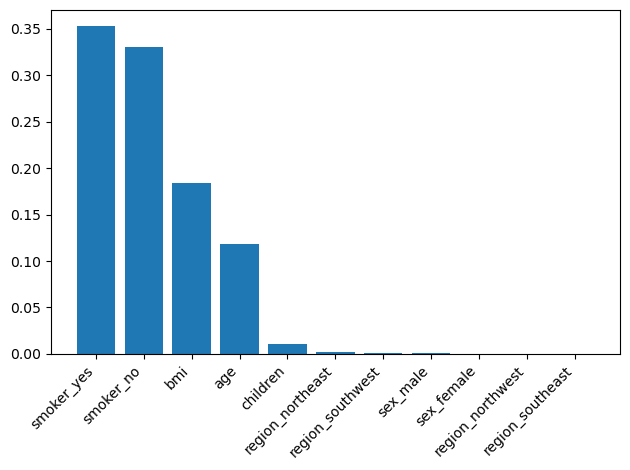

In [20]:
import numpy as np
import matplotlib.pyplot as plt

 
numeric_features = ["age","bmi","children"]
cat_feats = best_model.named_steps["preprocessor"] \
                      .named_transformers_["cat"] \
                      .named_steps["onehot"] \
                      .get_feature_names_out(["sex","smoker","region"])
feature_names = list(numeric_features) + list(cat_feats)

importances = best_model.named_steps["regressor"].feature_importances_
idx = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[idx])
plt.xticks(range(len(importances)), np.array(feature_names)[idx], rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

def load_data(path="insurance.csv"):
    return pd.read_csv(path)

def build_pipeline():
    numeric_features     = ["age", "bmi", "children"]
    categorical_features = ["sex", "smoker", "region"]
    
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ])
    
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore"))
    ])
    
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer,     numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])
    
    return Pipeline([
        ("preprocessor", preprocessor),
        ("regressor",   GradientBoostingRegressor(random_state=42))
    ])

def train_and_evaluate(X_train, y_train, X_test, y_test, pipeline):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    rmse  = mean_squared_error(y_test, preds, squared=False)
    r2    = r2_score(y_test, preds)
    return rmse, r2

if __name__ == "__main__":
    df = load_data()
    X  = df.drop(columns="charges")
    y  = df["charges"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    pipeline = build_pipeline()
    rmse, r2 = train_and_evaluate(X_train, y_train, X_test, y_test, pipeline)
    
    print(f"Final model → RMSE {rmse:.2f}, R² {r2:.4f}")
    joblib.dump(pipeline, "insurance_gb_pipeline.pkl")


Final model → RMSE 4328.15, R² 0.8793


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
